# Half-wave dipole
In this notebook, a center-driven half-wave dipole is modeled using the thin-wire MoM implementation.
 - Current distribution at resonance
 - Input impedance versus frequency
 - Far-field radiation pattern

In [14]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/PostProcessing.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [15]:
ε = 8.854e-12      # Vacuum permittivity [F/m]
μ = 4e-7 * π       # Vacuum permeability [H/m]

c = 1 / √(μ * ε)   # Speed of light in vacuum [m/s]
η = √(μ / ε)       # Impedance of vacuum [Ω]

376.73430918211017

# Generate mesh
Generate the mesh consisting of a single segment with $N_{el}$ elements. For the wire radius $a = 10^{-3}$, the antenna is resonant when it has a length of $0.479 \lambda$. The antenna wire is placed along the $y$-axis.

In [16]:
Nel = 35
l = (c / 144e6) * 0.479
a = 1e-3

nodes, edges = mesh_segment([0 -l / 2 0], [0 l / 2 0], Nel, 1)
end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.0 -0.4986184390800368 0.0; 0.0 -0.47012595684689185 0.0; … ; 0.0 0.47012595684689185 0.0; 0.0 0.4986184390800368 0.0], [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36]], [1, 36], [0.0 -1.0 0.0; 0.0 -1.0 0.0; … ; 0.0 -1.0 0.0; 0.0 -1.0 0.0], 0.001)

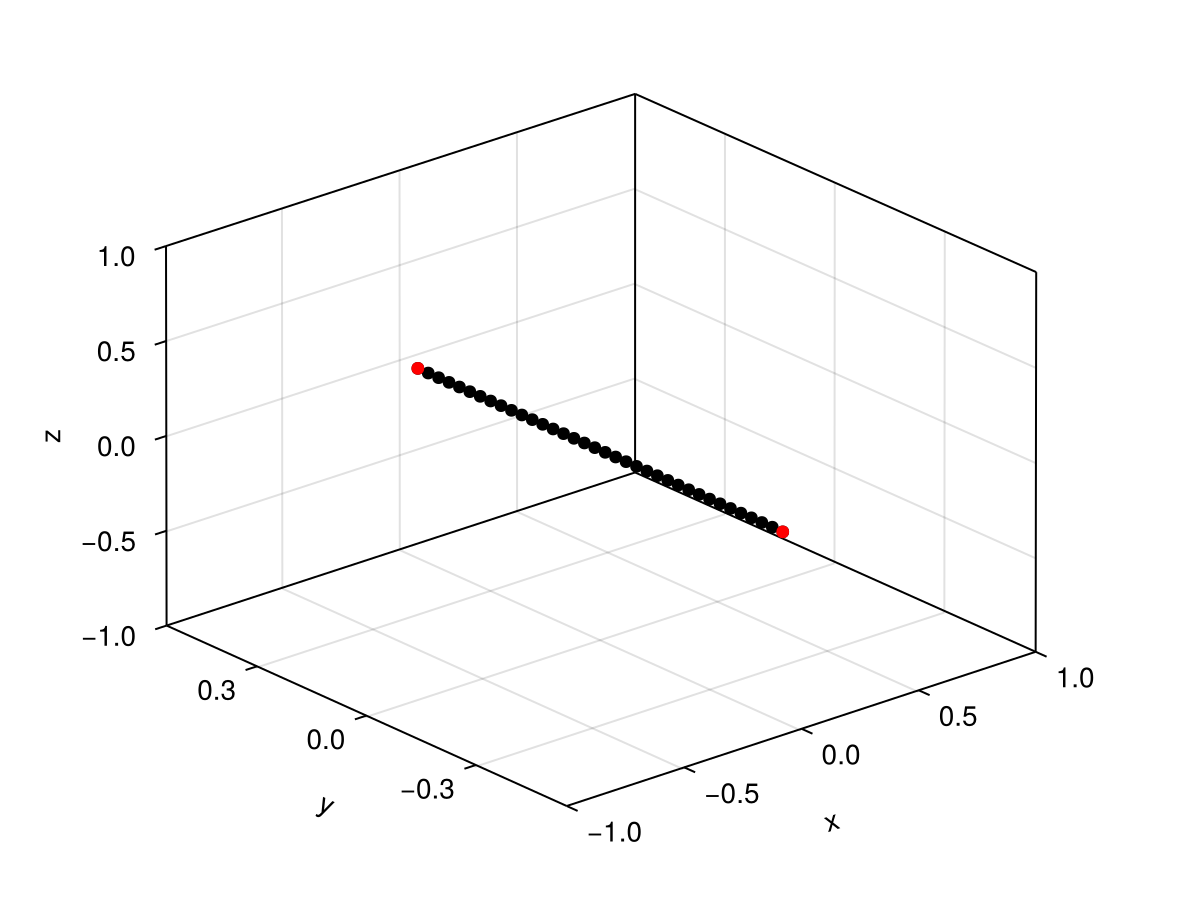

In [17]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources
The antenna is fed in the middle by a delta-gap voltage source $V_{in}$.

In [18]:
# Mid-point feed
Vin = 1
idx_mid = Integer(ceil(Nel / 2)) # Index of center element
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 18)

# Current distribution
The current distribution at resonance, and the corresponding input impedance are calculated.

Note that the imaginary part of the impedance is almost zero, indicating that the antenna is resonant at this frequency. The real part is very close to the ideally expected $73.1\,\Omega$.

In [19]:
reset_timer!()

# Assemble system equations
@timeit "assemble" Z, V = assemble_global(msh, src, 144e6, μ, ε)

# Solve system
@timeit "solve" Isol = Z \ V

print_timer()

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

println("\n\nImpedance at resonance: ", Zin, " Ω")

─────────────────────────────────────────────────────────────────────────
                                Time                    Allocations      
                       ───────────────────────   ────────────────────────
   Tot / % measured:        332ms /  99.0%           49.2MiB /  99.9%    

Section        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────
assemble            1    328ms  100.0%   328ms   49.1MiB  100.0%  49.1MiB
  outer loop        1    125ms   38.1%   125ms   39.1MiB   79.7%  39.1MiB
    element     1.23k    121ms   36.9%  98.8μs   37.1MiB   75.6%  31.0KiB
solve               1   69.7μs    0.0%  69.7μs   21.6KiB    0.0%  21.6KiB
─────────────────────────────────────────────────────────────────────────


Impedance at resonance: 71.90833200881792 + 0.20500766924736735im Ω


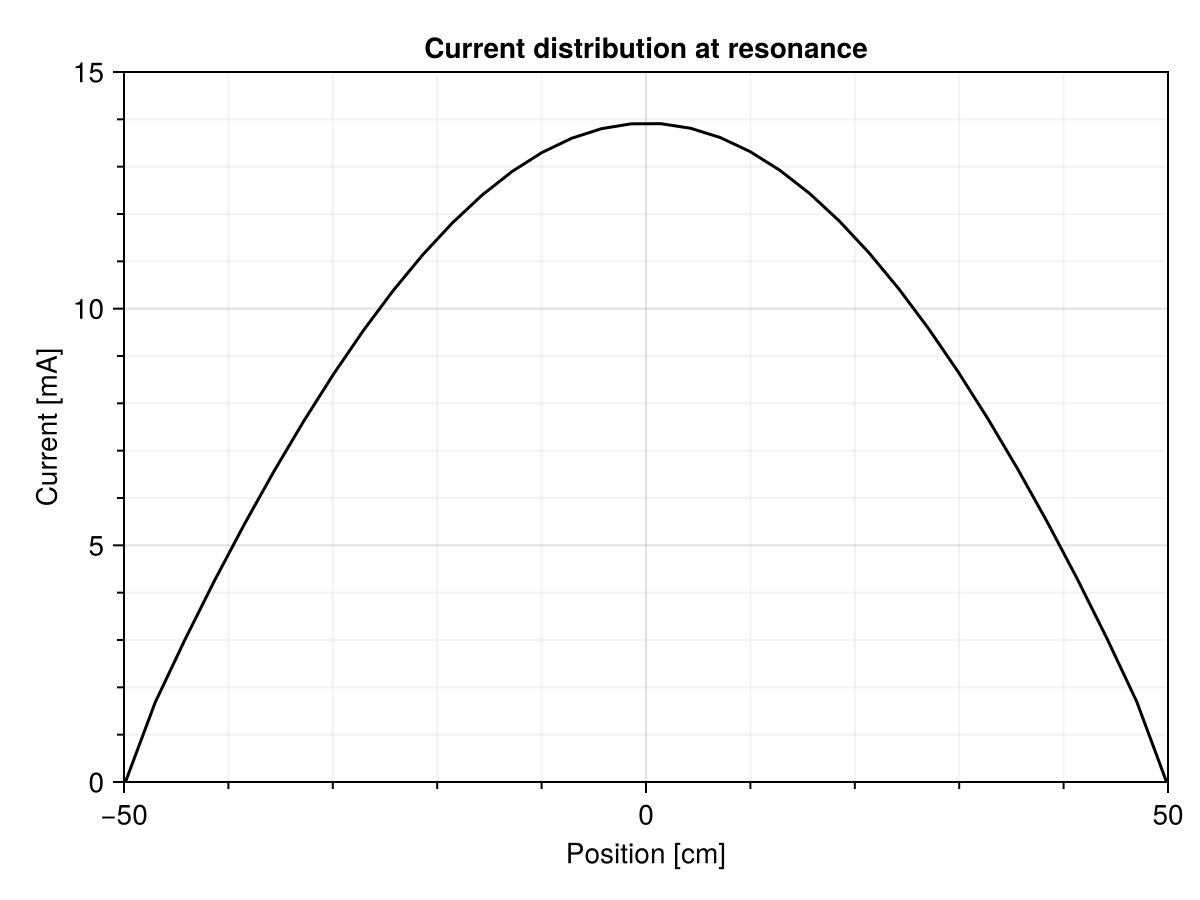

In [20]:
f = Figure()
ax = Axis(
    f[1, 1],
    xlabel="Position [cm]", ylabel="Current [mA]", title="Current distribution at resonance",
    limits=(-50, 50, 0, 15),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yminorticksvisible=true, yminorgridvisible=true, yminorticks=IntervalsBetween(5),
)

lines!(ax, msh.nodes[:, 2] * 1e2, abs.(Isol) * 1e3, color = :black)

f

# Frequency sweep
Next, we can solve the current distribution for a range of frequencies and plot the input impedance vs frequency.

In [21]:
# Input impedance frequency sweep
frequencies = range(50e6, 300e6, 50)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    # Calculate input impedance
    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

────────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
    Tot / % measured:          3.00s /  96.8%           1.86GiB /  99.9%    

Section           ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────
frequency sweep        1    2.90s  100.0%   2.90s   1.86GiB  100.0%  1.86GiB
  assembly            50    2.90s   99.9%  58.0ms   1.86GiB   99.9%  38.1MiB
    outer loop        50    2.90s   99.8%  57.9ms   1.86GiB   99.9%  38.1MiB
      element      61.2k    2.73s   94.0%  44.5μs   1.76GiB   94.7%  30.2KiB
  solve               50   2.20ms    0.1%  44.0μs   1.04MiB    0.1%  21.3KiB
────────────────────────────────────────────────────────────────────────────


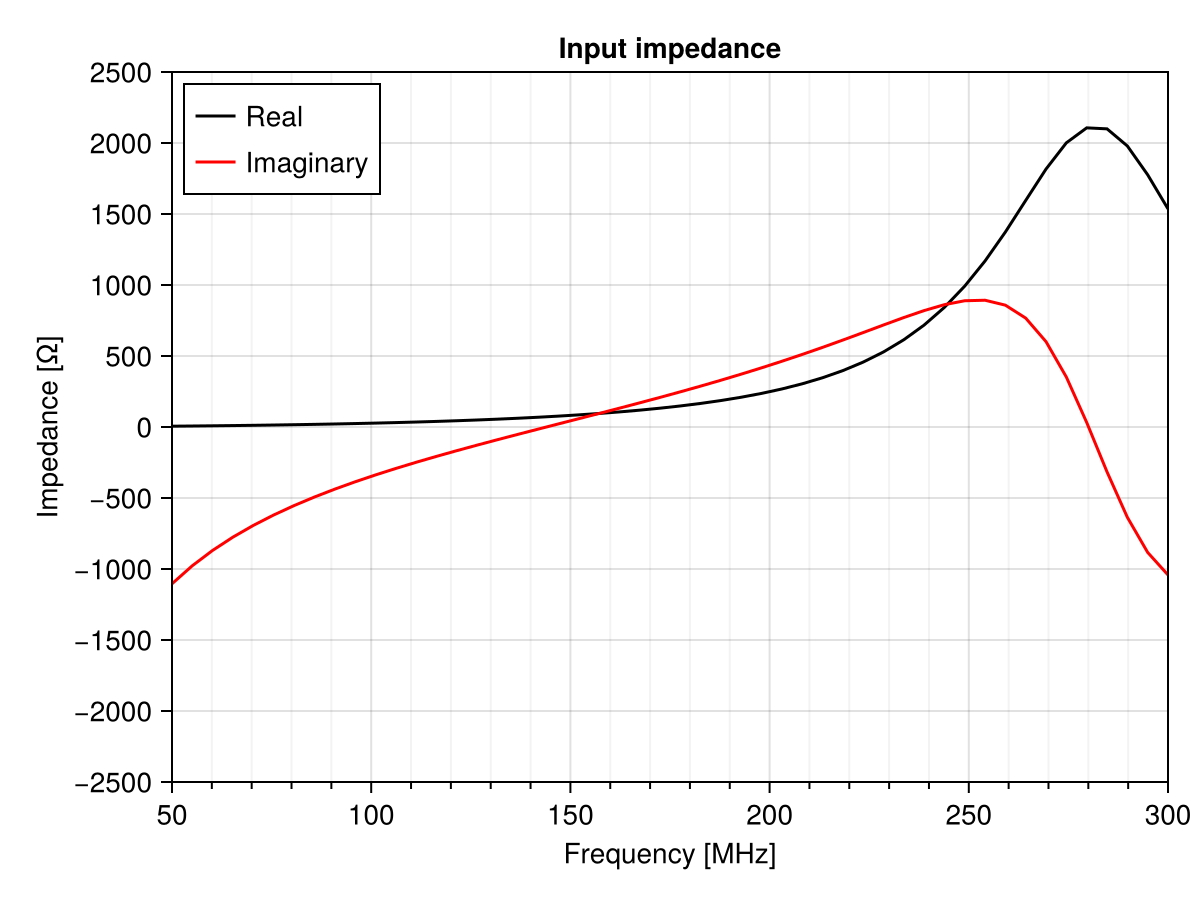

In [22]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input impedance",
    limits=(50, 300, -2500, 2500),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yticks=-2500:500:2500
)

lines!(ax, frequencies * 1e-6, real.(Zin), color=:black, label="Real")
lines!(ax, frequencies * 1e-6, imag.(Zin), color=:red, label="Imaginary")
axislegend(position = :lt)

f

# Far-field radiation pattern
The far-field radiation pattern is calculated using the far-field approximation at a distance of $100 \lambda$ from the antenna.

In [23]:
f = 144e6

# Solve currents
Z, V = assemble_global(msh, src, f, μ, ε)
Isol = Z \ V

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

reset_timer!()

# Calculate far field E-field
R = 100 * (c / f)       # Radius of evaluation points
N = 100                 # Number of evaluation points
θs = range(0, 2π, N)    # Evaluation angles

coords_xy = zeros(N, 3)
coords_xz = zeros(N, 3)
for (i, θ) ∈ enumerate(θs)
    coords_xy[i, :] = [(R * cos(θ)) (R * sin(θ)) 0]
    coords_xz[i, :] = [(R * cos(θ)) 0 (R * sin(θ))]
end

@timeit "FarField - xy" Exy = CalcFarField(msh, Isol, coords_xy, f, μ, ε);
@timeit "FarField - xz" Exz = CalcFarField(msh, Isol, coords_xz, f, μ, ε);

Pavg = Vin^2 / real(Zin) / (4π * R^2) # Power density of isotropic radiator

Pxy = norm.(eachrow(Exy)).^2 / η
Pxz = norm.(eachrow(Exz)).^2 / η

print_timer()

# Ideal E-field and radiated power for a half-wave dipole
Eideal = η * Vin / (2π * R * real(Zin)) * cos.(π/2 * cos.(θs .+ π/2)) ./ sin.(θs .+ π/2);
Pideal = Eideal.^2 / η;

────────────────────────────────────────────────────────────────────────────────
                                       Time                    Allocations      
                              ───────────────────────   ────────────────────────
      Tot / % measured:            161ms /  87.1%           23.8MiB /  98.8%    

Section               ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────
FarField - xy              1    126ms   89.7%   126ms   14.9MiB   63.5%  14.9MiB
  evaluation loop          1   14.3ms   10.2%  14.3ms   8.58MiB   36.5%  8.58MiB
    loop over edges      100   14.2ms   10.1%   142μs   8.39MiB   35.7%  85.9KiB
FarField - xz              1   14.4ms   10.3%  14.4ms   8.59MiB   36.5%  8.59MiB
  evaluation loop          1   14.3ms   10.2%  14.3ms   8.58MiB   36.5%  8.58MiB
    loop over edges      100   14.2ms   10.2%   142μs   8.39MiB   35.7%  85.9KiB
───────────────────────────

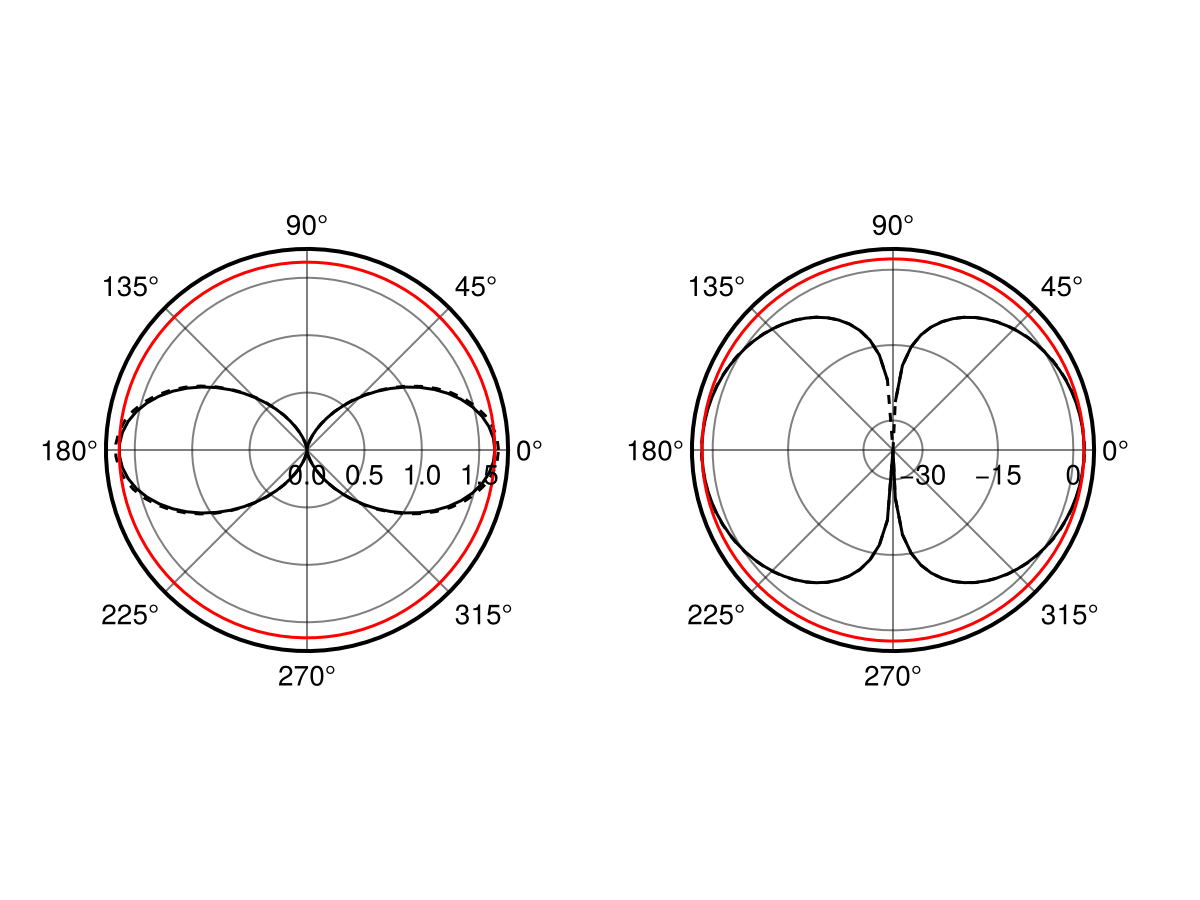

In [24]:
fig = Figure()

ax = PolarAxis(fig[1,1])
lines!(ax, θs, Pxy / Pavg, color = :black)
lines!(ax, θs, Pideal / Pavg, color = :black, linestyle = :dash)
lines!(ax, θs, Pxz / Pavg, color = :red)

ax = PolarAxis(fig[1,2])
lines!(ax, θs, 10 * log10.(Pxy / Pavg), color = :black)
lines!(ax, θs, 10 * log10.(Pideal / Pavg), color = :black, linestyle = :dash)
lines!(ax, θs, 10 * log10.(Pxz / Pavg), color = :red)

fig

Comparing the gain (expressed linearly or in terms of decibels compared to an isotropic radiator) with the the ideally expected gain shows a $2\,\%$ deviation.

In [25]:
Gain = maximum(Pxy / Pavg) # Gain 
Gideal = maximum(Pideal / Pavg); # Theoretical gain = 2.14 dBi

err = (Gain - Gideal) / Gideal * 100

println("Error w.r.t idealized model: ", err, " %")

Error w.r.t idealized model: -1.9088635605896447 %


The same antenna is modeled using EZNEC. At an angle of $45^\circ$, EZNEC gives a gain of $-4.01\,\textrm{dBmax} \equiv -1.87\,\textrm{dBi}$.

In [26]:
θ = 45π / 180
Efront = CalcFarField(msh, Isol, [R 0 0], f, μ, ε);
Eside = CalcFarField(msh, Isol, [R * cos(θ) R * sin(θ) 0], f, μ, ε);

Pfront = norm(Efront)^2 / η
Pside = norm(Eside)^2 / η

# Calculate the front-to-side ratio in dB
# Result from EZNEC: 4.01 dB
Rfs = 10 * log10(Pfront / Pside)

4.005644598338418